## Appendix: Multi-Seed Robustness Check

#### Fold-wise comparison

In [17]:
from src.config import WINDOW, HORIZON, USE_LOG1P, INITIAL_TRAIN_SIZE, TEST_BLOCK_SIZE, VAL_SIZE, PLOT_FOLD
from src.data import load_time_series_csv
from src.plots import plot_loss_curve, plot_test_predictions_overlay_residual
from src.backtest import run_backtest_residual

import pandas as pd

In [18]:
def compare_cases_foldwise(df_left, df_right, left_name="P", right_name="Res", metric_col="RMSE_model"):
    """
    Compare two result DataFrames fold-by-fold on the same metric.
    Returns:
      - cmp_df: per-fold merged table
      - summary: aggregate comparison stats
    """
    keep = ["fold", metric_col]

    l = df_left[keep].rename(columns={metric_col: f"{metric_col}_{left_name}"})
    r = df_right[keep].rename(
        columns={metric_col: f"{metric_col}_{right_name}"})

    cmp_df = l.merge(r, on="fold", how="inner")
    cmp_df[f"{right_name}_minus_{left_name}"] = (
        cmp_df[f"{metric_col}_{right_name}"] -
        cmp_df[f"{metric_col}_{left_name}"]
    )

    diff_col = f"{right_name}_minus_{left_name}"

    summary = {
        "metric": metric_col,
        "left": left_name,
        "right": right_name,
        "win_rate_right_better": float((cmp_df[diff_col] < 0).mean()),
        "mean_diff": float(cmp_df[diff_col].mean()),
        "median_diff": float(cmp_df[diff_col].median()),
        "best_diff": float(cmp_df[diff_col].min()),
        "worst_diff": float(cmp_df[diff_col].max()),
        "n_folds_compared": int(len(cmp_df)),
    }
    return cmp_df.sort_values(diff_col), summary

#### Run one seed

In [19]:
def run_one_seed_residual(
    seed,
    df,
    y_model,
    window,
    horizon,
    use_log1p,
    initial_train_size,
    test_block_size,
    val_size,
    plot_fold=0,
):
    # P
    df_P, art_P = run_backtest_residual(
        df=df,
        y_model=y_model,
        window=window,
        horizon=horizon,
        use_log1p=use_log1p,
        initial_train_size=initial_train_size,
        test_block_size=test_block_size,
        val_size=val_size,
        case_name="P",
        plot_fold=plot_fold,
        return_artifacts=True,
        seed=seed,
    )

    # Res
    df_Res, art_Res = run_backtest_residual(
        df=df,
        y_model=y_model,
        window=window,
        horizon=horizon,
        use_log1p=use_log1p,
        initial_train_size=initial_train_size,
        test_block_size=test_block_size,
        val_size=val_size,
        case_name="Res",
        plot_fold=plot_fold,
        return_artifacts=True,
        seed=seed,
    )

    # sanity check: same test block
    assert np.array_equal(art_Res["Res_target_index"],
                          art_P["P_target_index"])
    assert np.allclose(art_Res["Res_y_true_model"],
                       art_P["P_y_true_model"])

    art_plot = {**art_P, **art_Res}

    df_P = df_P.copy()
    df_Res = df_Res.copy()
    df_P["seed"] = seed
    df_Res["seed"] = seed

    return df_P, df_Res, art_plot

#### Multi-seed

In [20]:
def run_multi_seed_evaluation_residual_PA(
    seeds,
    df,
    y_model,
    window=WINDOW,
    horizon=HORIZON,
    use_log1p=USE_LOG1P,
    initial_train_size=INITIAL_TRAIN_SIZE,
    test_block_size=TEST_BLOCK_SIZE,
    val_size=VAL_SIZE,
    plot_seed=None,
    plot_fold=PLOT_FOLD,
    metric_col="RMSE_model",
    do_plots=True,
):
    if plot_seed is None:
        plot_seed = seeds[0]

    all_cmp = []
    seed_summaries = []
    art_for_plots = None

    for s in seeds:
        df_P, df_A, art_plot = run_one_seed_residual(
            seed=s,
            df=df,
            y_model=y_model,
            window=window,
            horizon=horizon,
            use_log1p=use_log1p,
            initial_train_size=initial_train_size,
            test_block_size=test_block_size,
            val_size=val_size,
            plot_fold=plot_fold,
        )

        cmp_df, summ = compare_cases_foldwise(
            df_left=df_P,
            df_right=df_A,
            left_name="P",
            right_name="Res",
            metric_col=metric_col,
        )
        cmp_df["seed"] = s
        all_cmp.append(cmp_df)
        seed_summaries.append({"seed": s, **summ})

        if s == plot_seed:
            art_for_plots = art_plot

    cmp_all = pd.concat(all_cmp, ignore_index=True)
    seed_summary_df = pd.DataFrame(seed_summaries).sort_values("seed")

    diff_col = "Res_minus_P"

    overall = {
        "metric": metric_col,
        "overall_win_rate_Res_better_than_P": float((cmp_all[diff_col] < 0).mean()),
        "overall_mean_Res_minus_P": float(cmp_all[diff_col].mean()),
        "overall_median_Res_minus_P": float(cmp_all[diff_col].median()),
        "overall_best_Res_minus_P": float(cmp_all[diff_col].min()),
        "overall_worst_Res_minus_P": float(cmp_all[diff_col].max()),
        "n_rows_total": int(len(cmp_all)),
        "n_seeds": int(len(seeds)),
    }

    if do_plots and art_for_plots is not None:
        plot_loss_curve(
            art_for_plots["Res_history"],
            title=f"Seed {plot_seed}, Fold {plot_fold}: Res train vs val loss",
        )
        plot_test_predictions_overlay_residual(
            art_for_plots,
            use_log1p=use_log1p,
            title=f"Seed {plot_seed}, Fold {plot_fold}: Actual vs P vs Res (test block)",
        )

    return cmp_all, seed_summary_df, overall

#### Results

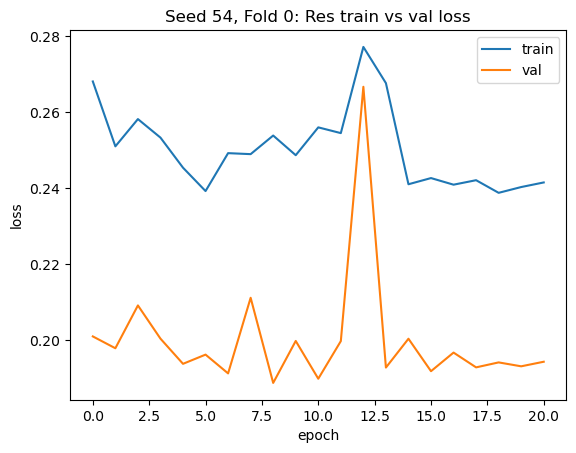

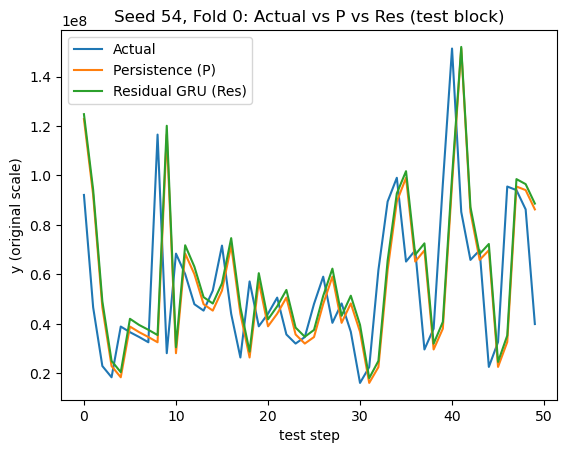

< Seed-level summaries >
   seed  win_rate_right_better     mean_diff  worst_diff   best_diff
0    54                0.78125 -2.893814e+06    965094.0 -19810432.0
1   123                0.84375 -2.889748e+06   1532288.0 -17661680.0
2   248                0.78125 -2.143168e+06   4233728.0 -15096096.0

< Overall summary >
{'metric': 'RMSE_orig', 'overall_win_rate_Res_better_than_P': 0.8020833333333334, 'overall_mean_Res_minus_P': -2642243.5, 'overall_median_Res_minus_P': -1339114.0, 'overall_best_Res_minus_P': -19810432.0, 'overall_worst_Res_minus_P': 4233728.0, 'n_rows_total': 96, 'n_seeds': 3}

< Fold-wise comparison head >
    fold  RMSE_orig_P  RMSE_orig_Res  Res_minus_P  seed
0     19  246292656.0    226482224.0  -19810432.0    54
1     21  195514224.0    179921120.0  -15593104.0    54
2     18  206643792.0    192223072.0  -14420720.0    54
3     20  149623728.0    141785616.0   -7838112.0    54
4     10   44349820.0     39634392.0   -4715428.0    54
5     13   58139216.0     540188

In [21]:
seeds = [54, 123, 248]
df, X_raw, y_raw, y_model, cov_cols, date_col, target_col = load_time_series_csv(
    use_log1p=USE_LOG1P)

cmp_all, seed_summary, overall = run_multi_seed_evaluation_residual_PA(
    seeds=seeds,
    df=df,
    y_model=y_model,
    window=WINDOW,
    horizon=HORIZON,
    use_log1p=USE_LOG1P,
    initial_train_size=INITIAL_TRAIN_SIZE,
    test_block_size=TEST_BLOCK_SIZE,
    val_size=VAL_SIZE,
    plot_seed=54,
    plot_fold=PLOT_FOLD,
    metric_col="RMSE_orig",
    do_plots=True,
)

print("< Seed-level summaries >")
print(seed_summary[["seed", "win_rate_right_better",
      "mean_diff", "worst_diff", "best_diff"]])

print("\n< Overall summary >")
print(overall)

print("\n< Fold-wise comparison head >")
print(cmp_all.sort_values(["seed", "Res_minus_P"]).head(20))